In [0]:
from google.colab import drive, files
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## import .py files in Google Colab
https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab

In [0]:
def getLocalFiles():
    _files = files.upload()
    if _files:
        for k, v in _files.items():
            open(k, 'wb').write(v)

getLocalFiles()

In [0]:
import os
import imgaug as aug
import tensorflow as tf
import numpy as np

from my_applications import *
from my_data import *
from my_gradcam import *
from my_model import *

Using TensorFlow backend.


### Global variables

In [0]:
ROOT_PATH = 'drive/My Drive/master1/medical_image_recognition/'
DATASET_NAME = 'cancer_cells'
DATASET_PATH = ROOT_PATH + 'datasets/' + DATASET_NAME + '/'
ARRAY_PATH = ROOT_PATH + 'arrays/' + DATASET_NAME + '/'
MODEL_PATH = ROOT_PATH + 'models/' + DATASET_NAME + '/'

HEIGHT, WIDTH, CHANNELS = 224, 224, 3

# the next instructions are used to make results reproducible
SEED = 1234
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
tf.set_random_seed(SEED)
aug.seed(SEED)

### Get the data class helper 

In [0]:
dataclass = data_helper(DATASET_NAME,
                        DATASET_PATH,
                        ARRAY_PATH,
                        height=HEIGHT,
                        width=WIDTH,
                        channels=CHANNELS,
                        histogram_equalization=False)

print(dataclass.directories)
print(dataclass.labels)

['test', 'train']
{'bookstore': 0, 'inside_bus': 1, 'library': 2}


### Load the data

In [0]:
#dataclass.save_images()
dataclass.get_images()

train_x = dataclass.x['train']
train_y = dataclass.y['train']
test_x  = dataclass.x['test']
test_y  = dataclass.y['test']
#val_x   = dataclass.x['val']
#val_y   = dataclass.y['val']

test: getting images from drive/My Drive/master1/medical_image_recognition/arrays/miniMIT_Etus/test(224,224,3).h5
Data shape : (120, 224, 224, 3)
Labels shape : (120, 3)
Found 120 images in 0 seconds.
train: getting images from drive/My Drive/master1/medical_image_recognition/arrays/miniMIT_Etus/train(224,224,3).h5
Data shape : (120, 224, 224, 3)
Labels shape : (120, 3)
Found 120 images in 0 seconds.


## Data augmentation

### imgaug

In [0]:
import imgaug.augmenters as iaa

augmenters = [
    iaa.Fliplr(0.5),             # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops         
    # Strengthen or weaken the contrast in each image.       
    iaa.ContrastNormalization((0.75, 1.5)),         
    #iaa.AdditiveGaussianNoise(
    #    loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
    
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )   
]

seq = iaa.Sequential(augmenters, random_order=True)


# show multiple transformation of a same image
#seq.show_grid([train_x[0]], cols=6, rows=2)

## CNN

In [0]:
import pandas as pd
df = pd.DataFrame(train_y, columns=dataclass.labels.keys())

for column in df.columns:
    print(f'{column} : {np.array(df[df[column] == 1]).sum()}')

bookstore : 40.0
inside_bus : 40.0
library : 40.0


In [0]:
class_weight_mapping = None #{0: 1.0, 1: 0.4}

In [0]:
def train_model_gen(model,
                    train_x,
                    train_y,
                    val_x,
                    val_y,
                    save_model_path,
                    epochs=50,
                    batch_size=32,
                    metric='val_loss',
                    save_best_only=True,
                    save_weights_only=True,
                    stop_after=10,
                    save_history=True,
                    save_history_path=None,
                    class_weight_mapping=None):
    """
    TODO
    """
    from keras.callbacks import EarlyStopping, ModelCheckpoint
    from keras.preprocessing.image import ImageDataGenerator
    import pickle
    
    if save_history and save_history_path is None:
        raise ValueError('You must define a path to save history.')

    # callbacks
    early_stopping = EarlyStopping(patience=stop_after,
                                   monitor=metric,
                                   restore_best_weights=True)

    checkpoint = ModelCheckpoint(save_model_path,
                                 monitor=metric,
                                 verbose=1,
                                 save_best_only=save_best_only,
                                 save_weights_only=save_weights_only)
    
    
    image_gen = ImageDataGenerator(preprocessing_function=seq.augment_image)
    train_gen = image_gen.flow(train_x, train_y, batch_size=batch_size)
    
    #xxx, yyy = next(train_gen)
    #for i in range(len(xxx)):
    #    print(yyy[i])
    #    plt.imshow(xxx[i])
    #    plt.show()
    #return None
    
    # get generator
    #train_gen = data_gen(train_x, train_y, batch_size=batch_size)
    #steps = ceil(len(train_x) / batch_size)
    #print('steps inside train modelz gen :', steps)

    # here we are, we'll train the model
    history = model.fit_generator(train_gen,
                                  steps_per_epoch=len(train_x) / batch_size,
                                  epochs=epochs,
                                  verbose=1,
                                  callbacks=[early_stopping, checkpoint],
                                  validation_data=(val_x, val_y),
                                  shuffle=True,
                                  class_weight=class_weight_mapping)

    # save history
    if save_history:
        with open(save_history_path, 'wb') as file:
            pickle.dump(history.history, file)
        print('\n\nSaved history into {}'.format(save_history_path))

    return model, history

In [0]:
# optimizers
from keras.optimizers import Adam
optimizer = Adam(lr=1e-4, decay=1e-5)

BATCH_SIZE = 32

# create the model
model = create_vgg19(dataclass.num_labels,
                     include_top=True,
                     input_shape=(dataclass.height,
                                  dataclass.width,
                                  dataclass.channels),
                     num_frozen_layers=None,
                     frozen_layers=['blocks', 'fc1'],
                     optimizers=optimizer)

# paths
save_model_path = MODEL_PATH + model.name + '.hdf5'
save_history_path = MODEL_PATH + model.name + '.history'

# training
train_model_gen(model,
                train_x,
                train_y,
                test_x,
                test_y,
                save_model_path,
                epochs=300,
                batch_size=BATCH_SIZE,
                metric='val_loss',
                save_best_only=True,
                save_weights_only=False,
                stop_after=20,
                save_history=True,
                save_history_path=save_history_path,
                class_weight_mapping=class_weight_mapping)

## Check metrics

In [0]:
from keras.models import load_model
model = load_model(save_model_path)

              precision    recall  f1-score   support

   bookstore       0.44      0.42      0.43        40
  inside_bus       0.00      0.00      0.00        40
     library       0.35      0.70      0.46        40

    accuracy                           0.38       120
   macro avg       0.26      0.38      0.30       120
weighted avg       0.26      0.38      0.30       120

Loading history from drive/My Drive/master1/medical_image_recognition/models/miniMIT_Etus/vgg19blocks_fc1.history


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

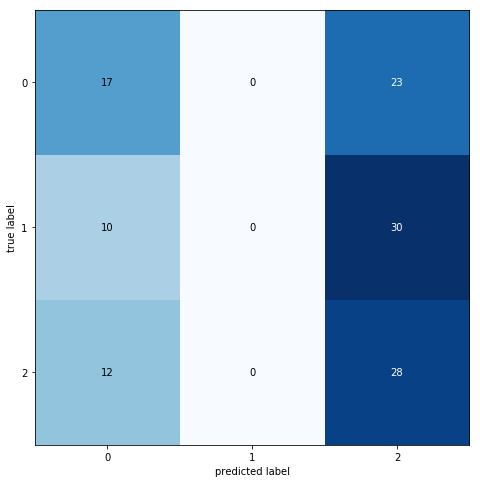

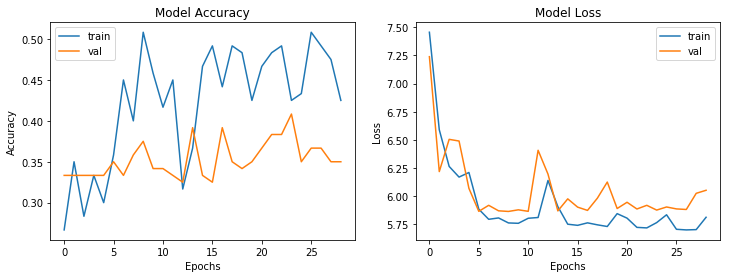

In [0]:
preds = np.argmax(model.predict(test_x), axis=-1)
ground_truth = np.argmax(test_y, axis=-1)

plot_model_performance(preds, ground_truth, dataclass.labels.keys())
plot_model_history(save_history_path)